# Chap03-5. 뉴스 기사 분류: 다중 분류 문제
이 notebook에서는 뉴스 텍스트 기반으로 로이터 뉴스를 46개의 토픽으로 나누는 다중 분류를 보여주겠습니다.  
<br />

### 로이터 데이터셋
1986년에 로이터에서 공개한 짧은 뉴스와 토픽의 집합인 **로이터 데이터셋**을 사용하겠습니다.  
46개의 토픽이 있으며 각 토픽은 훈련 세트에 10개 이상의 샘플을 가지고 있습니다.  
<br />
또한 로이터 데이터셋은 MNIST, IMDB 데이터셋과 마찬가지로 Keras에 포함되어 있습니다.

In [1]:
from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

IMDB 데이터셋과 마찬가지로 매개변수인 `num_words`는 가장 많은 빈도로 존재하는 단어 10000개만 사용하겠다는 것을 나타냅니다.  
한번 이 데이터가 어떻게 생겼는지 살펴보겠습니다.

In [2]:
print(len(train_data), len(test_data))

8982 2246


In [3]:
train_data[7]

[1,
 53,
 648,
 26,
 14,
 749,
 26,
 39,
 6207,
 5466,
 14,
 4922,
 4001,
 86,
 147,
 72,
 11,
 14,
 321,
 61,
 11,
 29,
 53,
 19,
 965,
 150,
 14,
 19,
 492,
 150,
 39,
 12,
 3200,
 3859,
 14,
 32,
 3327,
 5756,
 86,
 251,
 59,
 11,
 14,
 193,
 47,
 11,
 123,
 48,
 1642,
 346,
 9,
 29,
 39,
 235,
 338,
 46,
 5,
 2,
 323,
 5,
 187,
 5532,
 15,
 9,
 4315,
 6675,
 15,
 58,
 191,
 26,
 90,
 67,
 773,
 105,
 1642,
 346,
 9,
 29,
 39,
 235,
 46,
 7,
 2,
 304,
 5,
 1929,
 4016,
 15,
 9,
 4527,
 5086,
 15,
 58,
 158,
 26,
 90,
 67,
 773,
 17,
 12]

IMDB 데이터와 같이 단어 인덱스를 리스트로 가지고 있네요. 저번과 같이 원래 텍스트로 디코딩해보겠습니다.

In [4]:
word_index = reuters.get_word_index()

def decode_review(news):
    reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
    decode = ' '.join([reverse_word_index.get(i - 3, '?') for i in news])
    return decode

decode_review(train_data[0])

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

이제 신경망에 학습시킬 데이터를 처리할텐데, 저번과 같은 코드로 데이터를 인코딩 하겠습니다.

In [5]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

print("x_train ", x_train.shape)
print("x_test ", x_test.shape)

x_train  (8982, 10000)
x_test  (2246, 10000)


로이터 뉴스 문제(다중 분류 문제)는 리뷰 분석 문제와는 다르게 각 레이블이 리스트 형태로 존재하고 있기 때문에 학습하기에 알맞게 벡터화를 시킬 때 **원 핫 인코딩**을 시켜야 합니다.(물론 리스트를 정수 텐서로 바꾸는 것도 가능합니다.)

In [6]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

또한 학습 과정에서 사용할 검증 세트도 만들어봅시다.

In [7]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

신경망에 학습시킬 데이터가 모두 준비되었으니, 이제 모델을 만들도록 하겠습니다.  
<br />
이번에는 출력 클래스가 46개로 늘어나서 출력 차원이 훨씬 커졌습니다.  
한편 이전에 사용했던 Dense 층을 쌓으면 각 층은 이전 층의 출력에서 제공한 정보만 사용할 수 있는데, 한 층이 분류 문제에 필요한 어떤 정보를 누락하면 그 다음 층에서 이를 가져올 방법이 없습니다.  
이는 각층이 잠재적으로 **정보의 병목**이 될 수 있다는 의미인데요, 저번과 같은 모델의 16개의 차원을 가진 중간층을 사용한다면 46개의 출력층으로 정보를 보낼 때 정보의 병목현상이 발생할 확률이 높습니다.  
그래서 이번에는 저번보다 규모가 큰 층을 사용해 모델을 만들겠습니다.

In [8]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000, )))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

![NN structure](./images/nn-3.png)  
위 그림과 같은 모델을 만들었습니다.  
크기가 64인 두 개의 Dense 층 위에 크기가 46인 마지막 Dense 층을 쌓았는데요, 여기에서는 활성화 함수로 softmax 함수를 사용했습니다.  
각 입력 샘플마다 46개의 클래스(여기서는 토픽)에 속할 확률을 출력하고 46개의 값들을 전부 더하면 1이 됩니다.  
<br />
이제 이 모델을 컴파일하면 훈련시킬 준비를 마치게 됩니다.  
여기에서는 `categorical_crossentropy`라는 손실함수를 사용합니다.

In [9]:
model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

모델을 학습시킵시다.

In [10]:
history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=20,
                   batch_size=512,
                   validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 151us/step - loss: 2.6567 - acc: 0.5291 - val_loss: 1.7635 - val_acc: 0.6490
Epoch 2/20
7982/7982 [==============================] - 1s 91us/step - loss: 1.4394 - acc: 0.7052 - val_loss: 1.3299 - val_acc: 0.7010
Epoch 3/20
7982/7982 [==============================] - 1s 85us/step - loss: 1.0587 - acc: 0.7771 - val_loss: 1.1412 - val_acc: 0.7420
Epoch 4/20
7982/7982 [==============================] - 1s 87us/step - loss: 0.8327 - acc: 0.8232 - val_loss: 1.0335 - val_acc: 0.7860
Epoch 5/20
7982/7982 [==============================] - 1s 88us/step - loss: 0.6595 - acc: 0.8658 - val_loss: 0.9842 - val_acc: 0.7840
Epoch 6/20
7982/7982 [==============================] - 1s 95us/step - loss: 0.5323 - acc: 0.8895 - val_loss: 0.9309 - val_acc: 0.8090
Epoch 7/20
7982/7982 [==============================] - 1s 100us/step - loss: 0.4252 - acc: 0.9142 - val_loss: 0.8984 - val_acc: 0.8210
Epoch

저번 예제와 같이 제대로 학습이 되었는지 보기 위해서 훈련과 검증손실, 정확도를 그래프로 나타내보겠습니다.

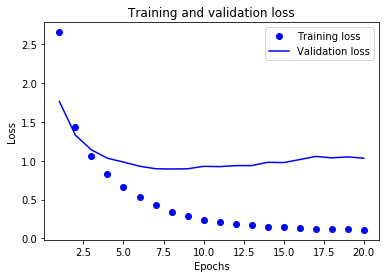

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label="Training loss")
plt.plot(epochs, val_loss, 'b', label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

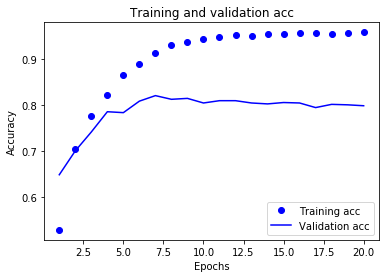

In [12]:
plt.clf()
acc = history_dict['acc']
val_acc = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label="Training acc")
plt.plot(epochs, val_acc, 'b', label="Validation acc")
plt.title("Training and validation acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

9번째 에포크 이후로 과대 적합이 시작되고 있습니다.  
이제 이를 바탕으로 아홉 번의 에포크 동안만 학습하는 새로운 모델을 만들어서 테스트 데이터로 확인해보겠습니다.

In [ ]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000, )))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

model.fit(partial_x_train,
          partial_y_train,
          epochs=9,
          batch_size=512,
          validation_data=(x_val, y_val))

model.evaluate(x_test, one_hot_test_labels)

대략 78%의 정확도를 가지게 됩니다.  
<br />
### 레이블을 인코딩하는 다른 방법: 정수 텐서로 변환
앞서 언급했던 것 처럼 레이블을 인코딩하는 방법으로는 원 핫 인코딩 외에도 다음과 같이 정수 텐서로 변환하는 방법이 있습니다.

In [ ]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

이 방법을 사용할 때는 손실 함수 하나만 바꾸면 됩니다.  
여기에서는 `categorical_crossentropy` 대신에 `sparse_categorical_crossentropy` 로 바꿔서 사용합니다.

In [ ]:
model.compile(optimizer='rmsprop',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

### 요약
* N개의 클래스로 데이터 포인트를 분류하려면 네트워크의 마지막 Dense층의 크기는 N이어야 합니다.
* 단일 레이블, 다중 분류 문제에서는 N개의 클래스에 대한 확률 분포를 출력하기 위해 `softmax`활성화 함수를 사용합니다.
* 이런 문제에는 항상 범주형 크로스 엔트로피를 사용해야 합니다. 이 함수는 모델이 출력한 확률 분포와 타깃 분포 사이의 거리를 최소화합니다.
* 다중 분류에서 레이블을 다루는 두 가지 방법이 있습니다.
    1. 레이블 범주형 인코딩(원-핫 인코딩)으로 인코딩하고 `categorical_crossentropy` 손실 함수를 사용합니다.
    2. 레이블을 정수로 인코딩하고 `sparse_categorical_crossentropy` 손실 함수를 사용합니다.
* 많은 수의 범주를 분류할 때 중간층의 크기가 너무 작아 네트워크에 정보의 병목이 생기지 않도록 해야 합니다.

## +) TensorFlow를 이용해 구현해보기

In [ ]:
import tensorflow as tf
from sklearn.utils import shuffle

# 데이터 셔플
x_train_, y_train_ = shuffle(x_train, one_hot_train_labels)
x_test_, y_test_ = shuffle(x_test, one_hot_test_labels)

# Placeholder 선언(feed할 데이터와 라벨)
inputs = tf.placeholder(tf.float32, [None, 10000])
labels = tf.placeholder(tf.float32, [None, 46])

# 모델 정의
nn1 = tf.layers.dense(inputs=inputs, units=64, activation=tf.nn.relu)
nn2 = tf.layers.dense(inputs=nn1, units=64, activation=tf.nn.relu)
logits = tf.layers.dense(inputs=nn2, units=46, activation=None)

# 손실 함수는 cross_entropy, 옵티마이저는 rmsprop 사용 (learning rate는 0.04)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels, logits=logits)
cross_entropy_mean = tf.reduce_mean(cross_entropy)
train_step = tf.train.RMSPropOptimizer(0.03).minimize(cross_entropy)

correct = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

# 학습 및 평가
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    # 배치 사이즈와 에포크 지정
    batch_size = 512
    training_epochs = 10

    for epoch in range(training_epochs):
        batch_count = int(x_train_.shape[0] / batch_size)
        for i in range(batch_count):
            batch_xs = x_train_[i * batch_size : min((i + 1) * batch_size, x_train_.shape[0])]
            batch_ys = y_train_[i * batch_size : min((i + 1) * batch_size, x_train_.shape[0])]

            sess.run(train_step, feed_dict={inputs: batch_xs, labels: batch_ys})

        loss, acc = sess.run([cross_entropy_mean, accuracy], feed_dict={inputs: batch_xs, labels: batch_ys})
        print('Epoch ' + str(epoch + 1) + '/' + str(training_epochs))
        print('loss: {:.4f} | accuracy: {:.4f}'.format(loss, acc))

    test_loss, test_acc = sess.run([cross_entropy_mean, accuracy], feed_dict={inputs: x_test_, labels: y_test_})
    print('\ntest loss: {:.4f} | test accuracy: {:.4f}'.format(test_loss, test_acc))